# **Installation**

In [ ]:
pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 74.9 MB/s eta 0:00:00


# **Libs**

In [ ]:
import pennylane as qml
from pennylane import numpy as pnp

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Dropout, Input, Conv2D, AvgPool2D, Flatten, BatchNormalization
from keras.utils import to_categorical

import tensorflow_probability as tfp

import numpy as np
from numpy.random import sample
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd

import sklearn
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.datasets import load_iris
from sklearn.kernel_ridge import KernelRidge

from sklearn.metrics import mean_squared_error,r2_score
from sklearn.linear_model import BayesianRidge,LinearRegression
import warnings
warnings.filterwarnings("ignore")

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# **Amplitude source code**

In [ ]:
from pennylane.ops import StatePrep
from pennylane.wires import Wires

# tolerance for normalization
TOLERANCE = 1e-10


class AmplitudeEmbedding(StatePrep):
    r"""Encodes :math:`2^n` features into the amplitude vector of :math:`n` qubits.

    By setting ``pad_with`` to a real or complex number, ``features`` is automatically padded to dimension
    :math:`2^n` where :math:`n` is the number of qubits used in the embedding.

    To represent a valid quantum state vector, the L2-norm of ``features`` must be one.
    The argument ``normalize`` can be set to ``True`` to automatically normalize the features.

    If both automatic padding and normalization are used, padding is executed *before* normalizing.

    .. note::

        On some devices, ``AmplitudeEmbedding`` must be the first operation of a quantum circuit.

    .. warning::

        At the moment, the ``features`` argument is **not differentiable** when using the template, and
        gradients with respect to the features cannot be computed by PennyLane.

    Args:
        features (tensor_like): input tensor of dimension ``(2^len(wires),)``, or less if `pad_with` is specified
        wires (Any or Iterable[Any]): wires that the template acts on
        pad_with (float or complex): if not None, the input is padded with this constant to size :math:`2^n`
        normalize (bool): whether to automatically normalize the features
        id (str): custom label given to an operator instance,
            can be useful for some applications where the instance has to be identified.

    Example:

        Amplitude embedding encodes a normalized :math:`2^n`-dimensional feature vector into the state
        of :math:`n` qubits:

        .. code-block:: python

            import pennylane as qml

            dev = qml.device('default.qubit', wires=2)

            @qml.qnode(dev)
            def circuit(f=None):
                qml.AmplitudeEmbedding(features=f, wires=range(2))
                return qml.expval(qml.PauliZ(0)), qml.state()

            res, state = circuit(f=[1/2, 1/2, 1/2, 1/2])

        The final state of the device is - up to a global phase - equivalent to the input passed to the circuit:

        >>> state
        tensor([0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j], requires_grad=True)

        **Differentiating with respect to the features**

        Due to non-trivial classical processing to construct the state preparation circuit,
        the features argument is in general **not differentiable**.

        **Normalization**

        The template will raise an error if the feature input is not normalized.
        One can set ``normalize=True`` to automatically normalize it:

        .. code-block:: python

            @qml.qnode(dev)
            def circuit(f=None):
                qml.AmplitudeEmbedding(features=f, wires=range(2), normalize=True)
                return qml.expval(qml.PauliZ(0)), qml.state()

            res, state = circuit(f=[15, 15, 15, 15])

        >>> state
        tensor([0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j], requires_grad=True)

        **Padding**

        If the dimension of the feature vector is smaller than the number of amplitudes,
        one can automatically pad it with a constant for the missing dimensions using the ``pad_with`` option:

        .. code-block:: python

            from math import sqrt

            @qml.qnode(dev)
            def circuit(f=None):
                qml.AmplitudeEmbedding(features=f, wires=range(2), pad_with=0.)
                return qml.expval(qml.PauliZ(0)), qml.state()

            res, state = circuit(f=[1/sqrt(2), 1/sqrt(2)])

        >>> state
        tensor([0.70710678+0.j, 0.70710678+0.j, 0.        +0.j, 0.        +0.j], requires_grad=True)

    """

    def __init__(self, features, wires, pad_with=None, normalize=False, id=None):
        # pylint:disable=bad-super-call
        wires = Wires(wires)
        self.pad_with = pad_with
        self.normalize = normalize
        features = self._preprocess(features, wires, pad_with, normalize)
        super(StatePrep, self).__init__(features, wires=wires, id=id)

    @staticmethod
    def compute_decomposition(
        features, wires
    ):  # pylint: disable=arguments-differ,arguments-renamed
        r"""Representation of the operator as a product of other operators.

        .. math:: O = O_1 O_2 \dots O_n.



        .. seealso:: :meth:`~.AmplitudeEmbedding.decomposition`.

        Args:
            features (tensor_like): input tensor of dimension ``(2^len(wires),)``
            wires (Any or Iterable[Any]): wires that the operator acts on

        Returns:
            list[.Operator]: decomposition of the operator

        **Example**

        >>> features = torch.tensor([1., 0., 0., 0.])
        >>> qml.AmplitudeEmbedding.compute_decomposition(features, wires=["a", "b"])
        [StatePrep(tensor([1., 0., 0., 0.]), wires=['a', 'b'])]
        """
        return [StatePrep(features, wires=wires)]


    @staticmethod
    def _preprocess(features, wires, pad_with, normalize):
        """Validate and pre-process inputs as follows:

        * If features is batched, the processing that follows is applied to each feature set in the batch.
        * Check that the features tensor is one-dimensional.
        * If pad_with is None, check that the last dimension of the features tensor
          has length :math:`2^n` where :math:`n` is the number of qubits. Else check that the
          last dimension of the features tensor is not larger than :math:`2^n` and pad features
          with value if necessary.
        * If normalize is false, check that last dimension of features is normalised to one. Else, normalise the
          features tensor.
        """

        # check if features is batched
        batched = qml.math.ndim(features) > 1

        # if batched and qml.math.get_interface(features) == "tensorflow":
        #     raise ValueError("AmplitudeEmbedding does not support batched Tensorflow features.")

        features_batch = features if batched else [features]

        new_features_batch = []
        # apply pre-processing to each features tensor in the batch
        for feature_set in features_batch:
            shape = qml.math.shape(feature_set)

            # check shape
            if len(shape) != 1:
                raise ValueError(f"Features must be a one-dimensional tensor; got shape {shape}.")

            n_features = shape[0]
            dim = 2 ** len(wires)
            if pad_with is None and n_features != dim:
                raise ValueError(
                    f"Features must be of length {dim}; got length {n_features}. "
                    f"Use the 'pad_with' argument for automated padding."
                )

            if pad_with is not None:
                if n_features > dim:
                    raise ValueError(
                        f"Features must be of length {dim} or "
                        f"smaller to be padded; got length {n_features}."
                    )

                # pad
                if n_features < dim:
                    padding = [pad_with] * (dim - n_features)
                    padding = qml.math.convert_like(padding, feature_set)
                    feature_set = qml.math.hstack([feature_set, padding])

            # normalize
            norm = qml.math.sum(qml.math.abs(feature_set) ** 2)

            if qml.math.is_abstract(norm):
                if normalize or pad_with:
                    feature_set = feature_set / qml.math.sqrt(norm)

            elif not qml.math.allclose(norm, 1.0, atol=TOLERANCE):
                if normalize or pad_with:
                    feature_set = feature_set / qml.math.sqrt(norm)
                else:
                    raise ValueError(
                        f"Features must be a vector of norm 1.0; got norm {norm}. "
                        "Use 'normalize=True' to automatically normalize."
                    )

            new_features_batch.append(feature_set)

        return qml.math.cast(
            qml.math.stack(new_features_batch) if batched else new_features_batch[0], np.complex128
        )

# **Data**

## **Data Generation**

In [ ]:
def gauss(A,mu,s,x):
  return A*(np.exp(-(x-mu)**2/(2*(s)**2)))

def logpoly(arr,f,f0):
  Tf=[]
  for i in range(len(f)):
    logf = np.log(f[i]/f0)
    tf = 0
    for j in range(4):
      tf+= arr[j]*logf**j
    Tf.append(tf)
  return np.exp(np.asarray(Tf))

In [ ]:
N = 2000 #no. of curves
Nf = 512
f = np.linspace(20,160,Nf)
f0 = 78.1
T0 = 2039.611
a0_init = np.log(T0)
#Generating paramters from a normal disribution
np.random.seed(1234)
A =  np.random.normal(-0.53,0.106,size=N)
mu = np.random.normal(78.1,15.62,size=N)
s = np.random.normal(18.7,3.74,size=N)
a0 = np.random.normal(a0_init,0.15*a0_init, size=N)
a1 = np.random.normal(-2.42096,0.1*2.42096,size=N)
a2 = np.random.normal(-0.08062,0.01*0.08062,size=N)
a3 = np.random.normal(-0.02898,0.01*0.02898,size=N)
a_arr = np.array([a0,a1,a2,a3]).T

In [ ]:
# Creating 1000 gaussian function with different parameters
X_gauss = []
for i in range(N):
  X_gauss.append(gauss(A[i],mu[i],s[i],f))
X_gauss = np.asarray(X_gauss)
# Creating 1000 linear function with different parameters
X_fg = []
for i in range(N):
  X_fg.append(logpoly(a_arr[i],f,f0))
X_fg = np.asarray(X_fg)

In [ ]:
X_data = X_gauss + X_fg
# Y_data = np.array([A,mu,s]).T
Y_data = np.array([A,mu,s,a0,a1,a2,a3]).T

In [ ]:
np.max(X_fg),np.min(X_fg)

(1697674.763486113, 9.05639618347936)

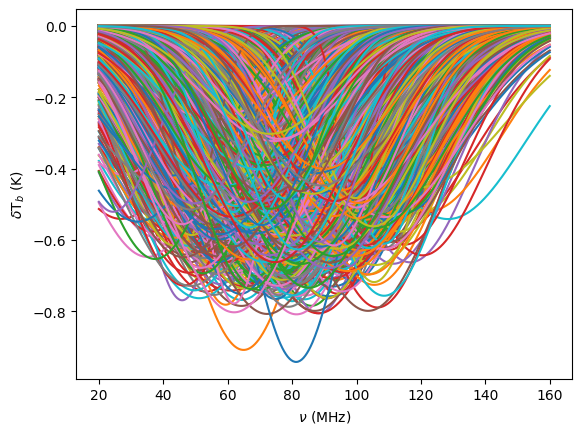

In [ ]:
for i in range(N):
  plt.plot(f,X_gauss[i,:])

plt.xlabel(r'$\nu$ (MHz)')
plt.ylabel(r'$\delta$T$_b$ (K)')
plt.savefig('gaussian_signal.png')

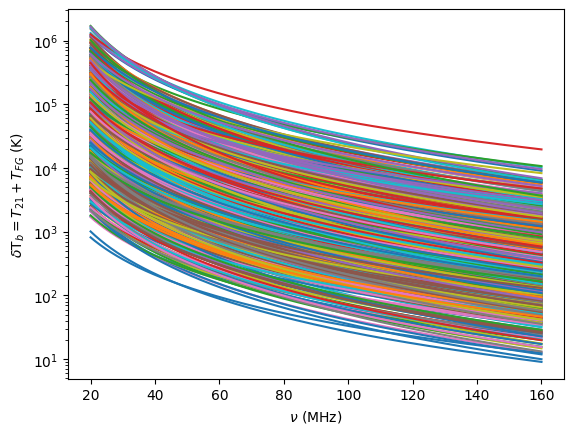

In [ ]:
for i in range(N):
  plt.plot(f,X_data[i,:])
plt.xlabel(r'$\nu$ (MHz)')
plt.ylabel(r'$\delta$T$_b$$=T_{21}+T_{FG}$ (K)')
plt.yscale('log')
plt.savefig('comb_signal.png')

Text(0, 0.5, '$\\delta$T$_b$$=T_{21}+T_{FG}$ (K)')

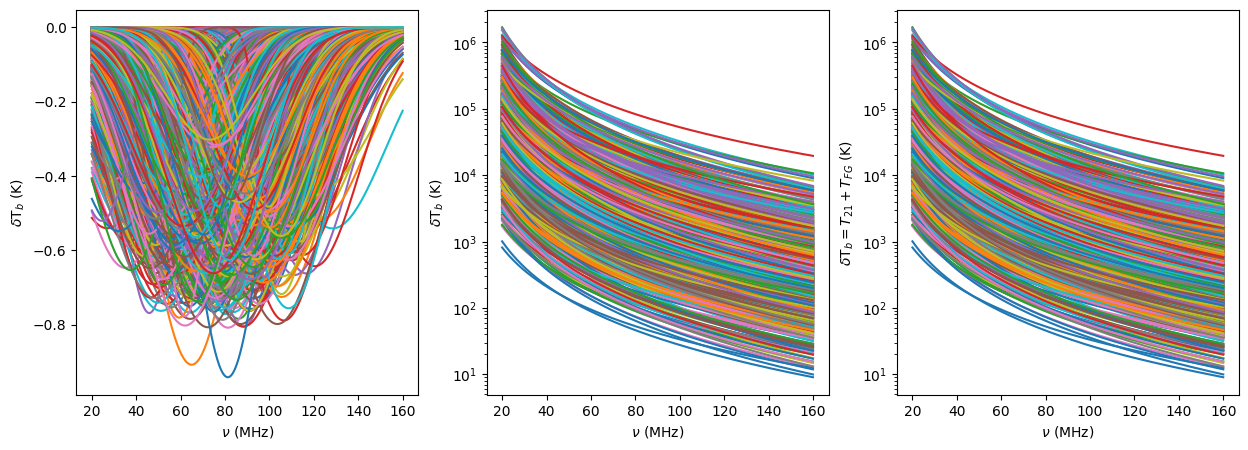

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
for i in range(N):
  ax[0].plot(f,X_gauss[i,:])
  ax[1].plot(f,X_fg[i,:])

for i in range(N):
  ax[2].plot(f,X_data[i,:])
ax[1].set_yscale('log')
ax[2].set_yscale('log')
# ax[0].set_title('Gaussian Function/Signal')
# ax[1].set_title('Foreground')
# ax[2].set_title('Observed/Combined data')
ax[0].set_xlabel(r'$\nu$ (MHz)')
ax[1].set_xlabel(r'$\nu$ (MHz)')
ax[2].set_xlabel(r'$\nu$ (MHz)')
ax[0].set_ylabel(r'$\delta$T$_b$ (K)')
ax[1].set_ylabel(r'$\delta$T$_b$ (K)')
ax[2].set_ylabel(r'$\delta$T$_b$$=T_{21}+T_{FG}$ (K)')

## **Scaling**

In [ ]:
scaler_x =  StandardScaler()
# scaler_x =  MinMaxScaler(feature_range=(-np.pi,np.pi),clip=True)
scaler_x.fit(X_data)
X = scaler_x.transform(X_data)

scaler_y = StandardScaler()
scaler_y.fit(Y_data)
Y = scaler_y.transform(Y_data)

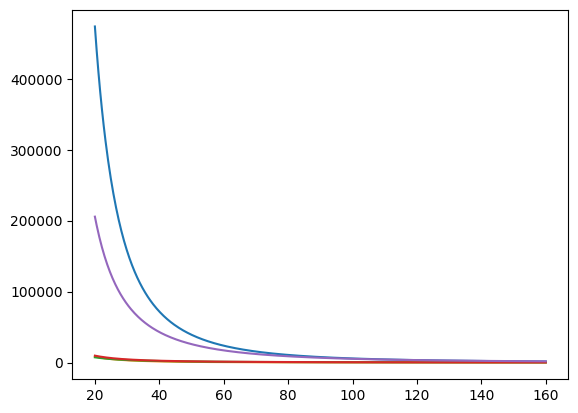

In [ ]:
for i in range(5):
  plt.plot(f,X_data[i,:])

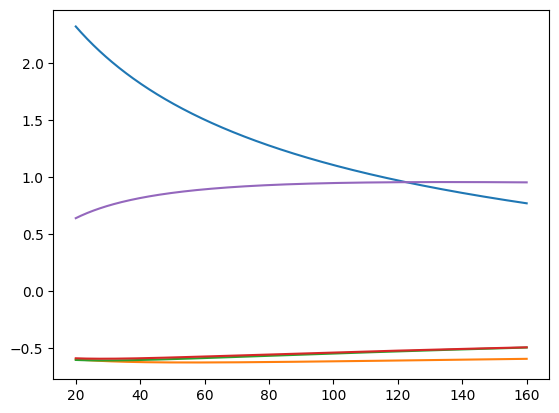

In [ ]:
for i in range(5):
  plt.plot(f,X[i,:])

## **Data Split**

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size = 0.1,random_state = 2)

In [ ]:
x_train, y_train = shuffle(x_train, y_train, random_state=2)

# **Parameter Estimation**

## **Only Signal**

In [ ]:
n_qubits =7
dev = qml.device('default.qubit', wires=n_qubits)

def vqc(weights):
    for j in range(weights.shape[0]):
      # for i in range(n_qubits-1):
      #   qml.IsingZZ(weights[j][i], wires=[i,i+1])
      for i in range(n_qubits):
        if i == n_qubits-1:
          qml.CNOT(wires=[i,0])
        else:
          qml.CNOT(wires=[i,i+1])
      # for i in range(n_qubits-1):
      #   qml.IsingXY(weights[j][i+n_qubits-1], wires=[i,i+1])
      for i in range(n_qubits):
        qml.U3(*weights[j][3*i+2*n_qubits-2:3*(i+1)+2*n_qubits-2],wires=i)
      qml.Barrier(wires=range(n_qubits))

In [ ]:
@qml.qnode(dev)
def qnn(inputs, weights):
    for i in range(n_qubits):
      qml.Hadamard(wires = i)
    qml.AngleEmbedding(inputs,wires=range(n_qubits),rotation = 'Z')
    vqc(weights)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

In [ ]:
# n_qubits =4# int(np.log2(Nf))
# dev = qml.device('default.qubit', wires=n_qubits)

# @qml.qnode(dev)
# def qnn(inputs, weights):
#     for i in range(n_qubits):
#       qml.Hadamard(wires = i)
#     qml.AngleEmbedding(inputs,wires=range(n_qubits),rotation = 'Z')
#     vqc(weights)
#     return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

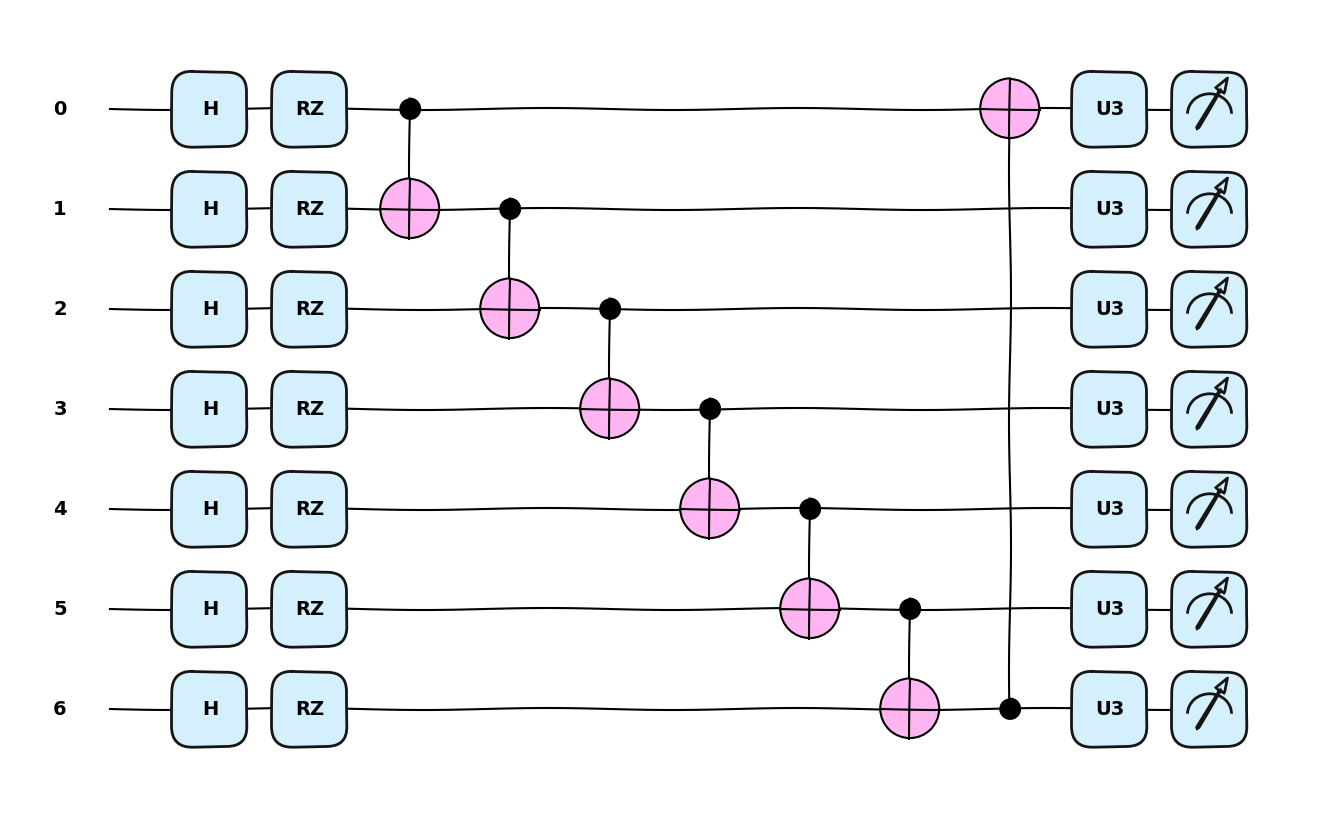

In [ ]:
ip = np.random.rand(n_qubits), np.random.rand(1,33)
fig, ax = qml.draw_mpl(qnn,style='pennylane',expansion_strategy = 'device')(*ip)
plt.show()

In [ ]:
weight_shapes_1 = {"weights": (4,33)}
weight_shapes_2 = {"weights": (4,33)}
weight_specs = {"weights": {"initializer": "random_uniform"}}

qlayer_1 = qml.qnn.KerasLayer(qnn, weight_shapes_1, output_dim=n_qubits)
qlayer_2 = qml.qnn.KerasLayer(qnn, weight_shapes_2, output_dim=n_qubits)

dense_1 = Dense(32,activation='tanh', input_shape=(Nf,),trainable=False)
dense_2 = Dense(n_qubits,activation='relu')
output = Dense(Y_data.shape[1],activation='linear')
hq_model = keras.Sequential([dense_1,dense_2,qlayer_1,output])
opt = tf.keras.optimizers.Adam(learning_rate=0.1)
# opt = tf.keras.optimizers.SGD(learning_rate=0.5)
hq_model.compile(opt, loss='mean_squared_error')

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=1e-3,
    patience=10,
    mode="auto",
    restore_best_weights=True,
    start_from_epoch=0,
)

In [ ]:
history = hq_model.fit(x_train, y_train, epochs=200, batch_size=512,validation_split=0.1,callbacks=[callback],verbose=1,shuffle=True)

Epoch 1/200
4/4 [==============================] - 7s 1s/step - loss: 0.9467 - val_loss: 0.7066
Epoch 2/200
4/4 [==============================] - 8s 2s/step - loss: 0.6770 - val_loss: 0.5031
Epoch 3/200
4/4 [==============================] - 7s 1s/step - loss: 0.5094 - val_loss: 0.3978
Epoch 4/200
4/4 [==============================] - 6s 1s/step - loss: 0.4457 - val_loss: 0.3620
Epoch 5/200
4/4 [==============================] - 7s 2s/step - loss: 0.4134 - val_loss: 0.3398
Epoch 6/200
4/4 [==============================] - 6s 1s/step - loss: 0.3794 - val_loss: 0.3297
Epoch 7/200
4/4 [==============================] - 7s 2s/step - loss: 0.3484 - val_loss: 0.2968
Epoch 8/200
4/4 [==============================] - 5s 1s/step - loss: 0.3174 - val_loss: 0.2590
Epoch 9/200
4/4 [==============================] - 6s 2s/step - loss: 0.2785 - val_loss: 0.2998
Epoch 10/200
4/4 [==============================] - 6s 1s/step - loss: 0.2579 - val_loss: 0.2333
Epoch 11/200
4/4 [=====================

In [ ]:
hq_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 32)                16416     
                                                                 
 dense_7 (Dense)             (None, 7)                 231       
                                                                 
 keras_layer_4 (KerasLayer)  (None, 7)                 132       
                                                                 
 dense_8 (Dense)             (None, 3)                 24        
                                                                 
Total params: 16803 (65.64 KB)
Trainable params: 387 (1.51 KB)
Non-trainable params: 16416 (64.12 KB)
_________________________________________________________________


In [ ]:
loss= history.history['loss']
val_loss = history.history['val_loss']
# accuracy = history.history['accuracy']
# val_accuracy = history.history['val_accuracy']

Text(0, 0.5, 'Validation Loss')

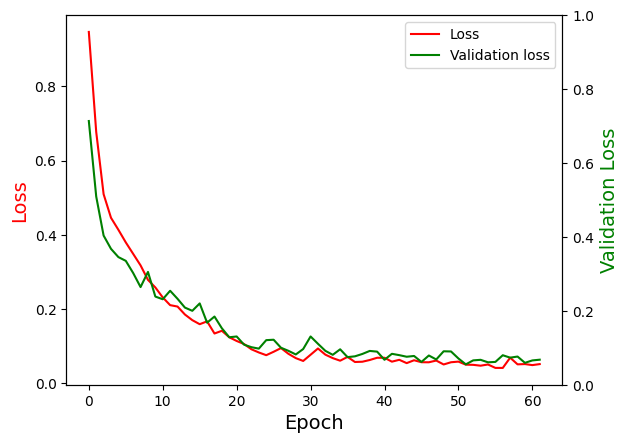

In [ ]:
fig,ax = plt.subplots()
ax.plot(loss, color="red", label= 'Loss')
ax.plot( val_loss, color="green", label= 'Validation loss')
ax.legend()
ax.set_xlabel("Epoch",fontsize=14)
ax.set_ylabel("Loss",color="red",fontsize=14)
ax2=ax.twinx()
ax2.set_ylabel("Validation Loss",color="green",fontsize=14)

In [ ]:
test_loss = hq_model.evaluate(x_test,y_test)

7/7 [==============================] - 2s 263ms/step - loss: 0.0518


In [ ]:
# Compute the output

Y_pre = hq_model.predict(x_test)

Y_pred = scaler_y.inverse_transform(Y_pre)
Y_test = scaler_y.inverse_transform(y_test)


# R2 Score
r2score= r2_score(y_test, Y_pre, multioutput='uniform_average')
Amplitude_r2score= r2_score(y_test[:,0], Y_pre[:,0])
print("Amplitude_R2score=", Amplitude_r2score)

Mean_r2score= r2_score(y_test[:,1], Y_pre[:,1])
print("Mean_R2score=", Mean_r2score)

Std_Deviation_r2score= r2_score(y_test[:,2], Y_pre[:,2])
print("Std_Deviation_R2score=", Std_Deviation_r2score)


from math import sqrt
#RMSE Score
mse = mean_squared_error(y_test, Y_pre, multioutput='raw_values')
A_rmse= sqrt(mse[0])
m_rmse= sqrt(mse[1])
std_rmse= sqrt(mse[2])

print("Amplitude_RMSE=",A_rmse)
print("Mean_RMSE=",m_rmse)
print("Std_Deviation_RMSE=",std_rmse)

7/7 [==============================] - 2s 257ms/step
Amplitude_R2score= 0.9335927901336408
Mean_R2score= 0.9733785522935795
Std_Deviation_R2score= 0.9042319468971828
Amplitude_RMSE= 0.23507421279601454
Mean_RMSE= 0.14977420366390434
Std_Deviation_RMSE= 0.2789041590465238


In [ ]:
r2_score(y_test,Y_pre)

0.9370677631081344

In [ ]:
h,y,z, =Y_pred[0]
h1,y1,z1 = Y_test[0]

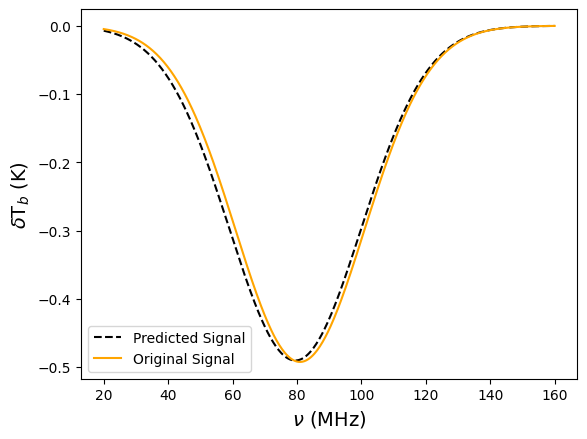

In [ ]:
plt.plot(f,gauss(h,y,z,f),color='black',linestyle='--',label = 'Predicted Signal')
plt.plot(f,gauss(h1,y1,z1,f),color='orange',label = 'Original Signal')
plt.xlabel(r'$\nu$ (MHz)',fontsize = 14)
plt.ylabel(r'$\delta$T$_b$ (K)',fontsize = 14)
# plt.xticks(np.arange(20,160,70))
# plt.yticks(np.arange(0,-1.0,100))
plt.legend()
plt.savefig("OnlySignal.png")

[83 66 28 36 58 93 75  8 61 28]


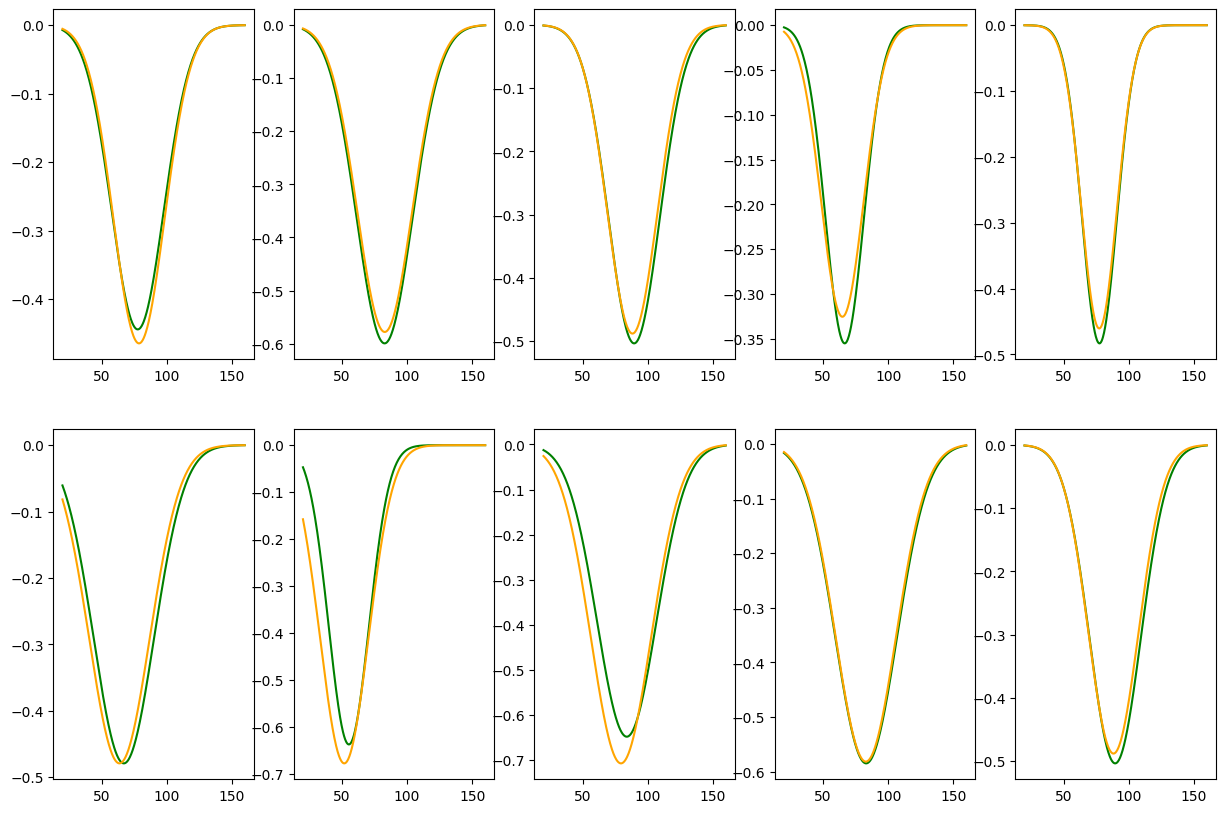

In [ ]:
# np.random.seed(5)
fig,ax = plt.subplots(2,5,figsize=(15,10))
indx = np.random.randint(low=0,high=99,size=10)
print(indx)
for i in range(2):
  if i==0:
    ind = indx[:5]
  else:
    ind = indx[5:]
  for j in range(len(ind)):
    h,y,z =Y_pred[ind[j]]
    h1,y1,z1 = Y_test[ind[j]]
    ax[i][j].plot(f,gauss(h,y,z,f),color='green')
    ax[i][j].plot(f,gauss(h1,y1,z1,f),color='orange')

In [ ]:
Amp, meanh, stdh = Y_pred.T
Ampt, meant, stdt = Y_test.T

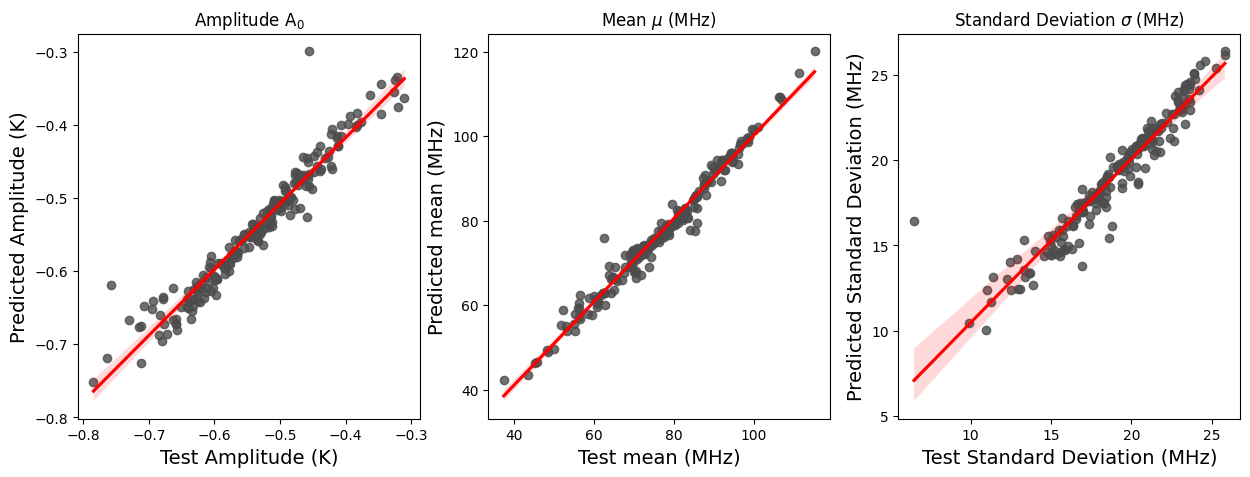

In [ ]:
fig,axe = plt.subplots(1,3,figsize= (15,5))
sns.regplot(x=Ampt,y=Amp,ax=axe[0],ci=99, marker="o", color=".3", line_kws=dict(color="r"))
sns.regplot(x=meant,y=meanh,ax=axe[1],ci=99, marker="o", color=".3", line_kws=dict(color="r"))
sns.regplot(x=stdt,y=stdh,ax=axe[2],ci=99, marker="o", color=".3", line_kws=dict(color="r"))
axe[0].set_xlabel('Test Amplitude (K)',fontsize = 14)
axe[0].set_ylabel('Predicted Amplitude (K)',fontsize = 14)
axe[1].set_xlabel('Test mean (MHz)',fontsize = 14)
axe[1].set_ylabel('Predicted mean (MHz)',fontsize = 14)
axe[2].set_xlabel('Test Standard Deviation (MHz)',fontsize = 14)
axe[2].set_ylabel('Predicted Standard Deviation (MHz)',fontsize = 14)
axe[0].set_title('Amplitude A$_{0}$')
axe[1].set_title('Mean ' r'$ \mu$ (MHz)')
axe[2].set_title('Standard Deviation ' r'$ \sigma$ (MHz)')
plt.savefig('predsonly.png')

## **Signal+Foreground**

In [ ]:
n_qubits =7
dev = qml.device('default.qubit', wires=n_qubits)

def vqc(weights):
    for j in range(weights.shape[0]):
      # for i in range(n_qubits-1):
      #   qml.IsingZZ(weights[j][i], wires=[i,i+1])
      for i in range(n_qubits):
        if i == n_qubits-1:
          qml.CNOT(wires=[i,0])
        else:
          qml.CNOT(wires=[i,i+1])
      # for i in range(n_qubits-1):
      #   qml.IsingXY(weights[j][i+n_qubits-1], wires=[i,i+1])
      for i in range(n_qubits):
        qml.U3(*weights[j][3*i+2*n_qubits-2:3*(i+1)+2*n_qubits-2],wires=i)
      qml.Barrier(wires=range(n_qubits))

In [ ]:
@qml.qnode(dev)
def qnn(inputs, weights):
    for i in range(n_qubits):
      qml.Hadamard(wires = i)
    qml.AngleEmbedding(inputs,wires=range(n_qubits),rotation = 'Z')
    vqc(weights)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

In [ ]:
weight_shapes_1 = {"weights": (4,5*n_qubits-2)}
# weight_shapes_2 = {"weights": (4,33)}
weight_specs = {"weights": {"initializer": "random_uniform"}}

qlayer_1 = qml.qnn.KerasLayer(qnn, weight_shapes_1, output_dim=n_qubits)
# qlayer_2 = qml.qnn.KerasLayer(qnn, weight_shapes_2, output_dim=n_qubits)

dense_1 = Dense(32,activation='tanh', input_shape=(Nf,),trainable=False)
dense_2 = Dense(n_qubits,activation='tanh')
dense_3 = Dense(n_qubits,activation='tanh')
output = Dense(Y_data.shape[1],activation='linear')
hq_model = keras.Sequential([dense_1,dense_2,qlayer_1,output])
opt = tf.keras.optimizers.Adam(learning_rate=0.1)
# opt = tf.keras.optimizers.SGD(learning_rate=0.5)
hq_model.compile(opt, loss='mean_squared_error')

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=1e-3,
    patience=10,
    mode="auto",
    restore_best_weights=True,
    start_from_epoch=0,
)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3, decay_steps=1000, decay_rate=0.9)
opt = tf.keras.optimizers.Adam(learning_rate=0.1)
# opt = tf.keras.optimizers.SGD(learning_rate=0.5)
hq_model.compile(opt, loss='mean_squared_error')

In [ ]:
history = hq_model.fit(x_train, y_train, epochs=100, batch_size=512,callbacks=[callback],validation_split=0.1,verbose=1,shuffle=True)

Epoch 1/100
4/4 [==============================] - 5s 1s/step - loss: 1.0331 - val_loss: 1.0255
Epoch 2/100
4/4 [==============================] - 3s 832ms/step - loss: 0.9855 - val_loss: 0.9749
Epoch 3/100
4/4 [==============================] - 3s 833ms/step - loss: 0.9430 - val_loss: 0.9473
Epoch 4/100
4/4 [==============================] - 4s 971ms/step - loss: 0.9065 - val_loss: 0.9275
Epoch 5/100
4/4 [==============================] - 4s 1s/step - loss: 0.8772 - val_loss: 0.8875
Epoch 6/100
4/4 [==============================] - 3s 824ms/step - loss: 0.8492 - val_loss: 0.8454
Epoch 7/100
4/4 [==============================] - 3s 837ms/step - loss: 0.8122 - val_loss: 0.8155
Epoch 8/100
4/4 [==============================] - 4s 1s/step - loss: 0.7849 - val_loss: 0.8070
Epoch 9/100
4/4 [==============================] - 4s 1s/step - loss: 0.7739 - val_loss: 0.7942
Epoch 10/100
4/4 [==============================] - 3s 828ms/step - loss: 0.7678 - val_loss: 0.7870
Epoch 11/100
4/4 [===

In [ ]:
hq_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 32)                16416     
                                                                 
 dense_33 (Dense)            (None, 7)                 231       
                                                                 
 keras_layer_9 (KerasLayer)  (None, 7)                 132       
                                                                 
 dense_35 (Dense)            (None, 7)                 56        
                                                                 
Total params: 16835 (65.76 KB)
Trainable params: 419 (1.64 KB)
Non-trainable params: 16416 (64.12 KB)
_________________________________________________________________


In [ ]:
loss= history.history['loss']
val_loss = history.history['val_loss']
# accuracy = history.history['accuracy']
# val_accuracy = history.history['val_accuracy']

Text(0, 0.5, 'Validation Loss')

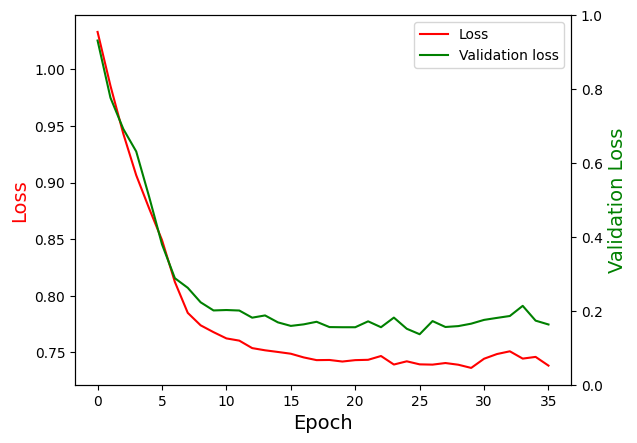

In [ ]:
fig,ax = plt.subplots()
ax.plot(loss, color="red", label= 'Loss')
ax.plot( val_loss, color="green", label= 'Validation loss')
ax.legend()
ax.set_xlabel("Epoch",fontsize=14)
ax.set_ylabel("Loss",color="red",fontsize=14)
ax2=ax.twinx()
ax2.set_ylabel("Validation Loss",color="green",fontsize=14)


In [ ]:
test_loss = hq_model.evaluate(x_test,y_test)

7/7 [==============================] - 2s 289ms/step - loss: 0.6776


In [ ]:
# Compute the output

Y_pre = hq_model.predict(x_test)

Y_pred = scaler_y.inverse_transform(Y_pre)
Y_test = scaler_y.inverse_transform(y_test)


# R2 Score
r2score= r2_score(y_test, Y_pre, multioutput='uniform_average')
Amplitude_r2score= r2_score(y_test[:,0], Y_pre[:,0])
print("Amplitude_R2score=", Amplitude_r2score)

Mean_r2score= r2_score(y_test[:,1], Y_pre[:,1])
print("Mean_R2score=", Mean_r2score)

Std_Deviation_r2score= r2_score(y_test[:,2], Y_pre[:,2])
print("Std_Deviation_R2score=", Std_Deviation_r2score)

a0_r2score= r2_score(y_test[:,3], Y_pre[:,3])
print("a0_R2score=",a0_r2score )

a1_r2score= r2_score(y_test[:,4], Y_pre[:,4])
print("a1_R2score=",a1_r2score)

a2_r2score= r2_score(y_test[:,5], Y_pre[:,5])
print("a2_R2score=",a2_r2score )

a3_r2score= r2_score(y_test[:,6], Y_pre[:,6])
print("a3_R2score=",a3_r2score)

from math import sqrt
#RMSE Score
mse = mean_squared_error(y_test, Y_pre, multioutput='raw_values')
A_rmse= sqrt(mse[0])
m_rmse= sqrt(mse[1])
std_rmse= sqrt(mse[2])
a0_rmse= sqrt(mse[3])
a1_rmse= sqrt(mse[4])
a2_rmse= sqrt(mse[5])
a3_rmse= sqrt(mse[6])
print("Amplitude_RMSE=",A_rmse)
print("Mean_RMSE=",m_rmse)
print("Std_Deviation_RMSE=",std_rmse)
print("a0_RMSE=",a0_rmse)
print("a1_RMSE=",a1_rmse)
print("a2_RMSE=",a2_rmse)
print("a3_RMSE=",a3_rmse)

7/7 [==============================] - 2s 284ms/step
Amplitude_R2score= -0.03473170043177176
Mean_R2score= -0.013786758132471544
Std_Deviation_R2score= -0.01932383278941563
a0_R2score= 0.9484954409434685
a1_R2score= 0.9113929390295799
a2_R2score= -0.0012947499078794777
a3_R2score= 0.00013206434350521157
Amplitude_RMSE= 0.9279215287693894
Mean_RMSE= 0.9242607099001718
Std_Deviation_RMSE= 0.9099148451151825
a0_RMSE= 0.21415679386122857
a1_RMSE= 0.28889780799744463
a2_RMSE= 1.0375854481978128
a3_RMSE= 0.9970807544793651


In [ ]:
r2_score(y_test,Y_pre)

0.2558404861507167

In [ ]:
h,y,z,w,u,v,i =Y_pred[0]
h1,y1,z1,w1,u1,v1,i1 = Y_test[0]

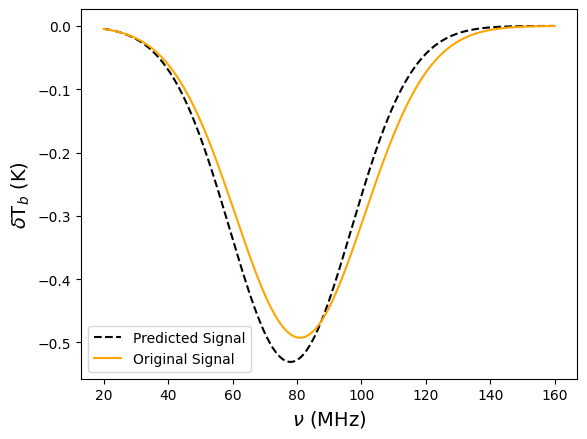

In [ ]:
plt.plot(f,gauss(h,y,z,f),color='black',linestyle='--',label = 'Predicted Signal')
plt.plot(f,gauss(h1,y1,z1,f),color='orange',label = 'Original Signal')
plt.xlabel(r'$\nu$ (MHz)',fontsize=14)
plt.ylabel(r'$\delta$T$_b$ (K)',fontsize=14)
plt.legend()
plt.savefig("OnlySignal.png")

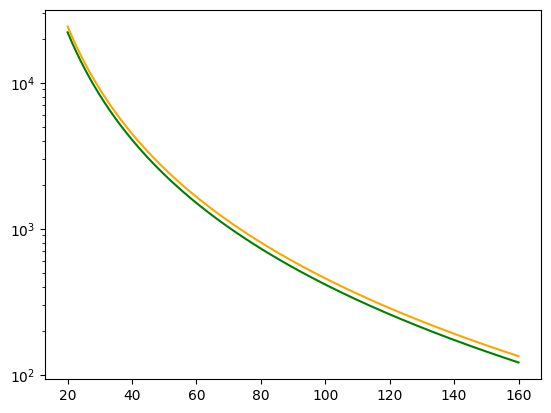

In [ ]:
plt.plot(f,logpoly([w,u,v,i],f,f0),color='green')
plt.plot(f,logpoly([w1,u1,v1,i1],f,f0),color='orange')
plt.yscale('log')

[19  7 98 86 83 46 38 93 94 25]


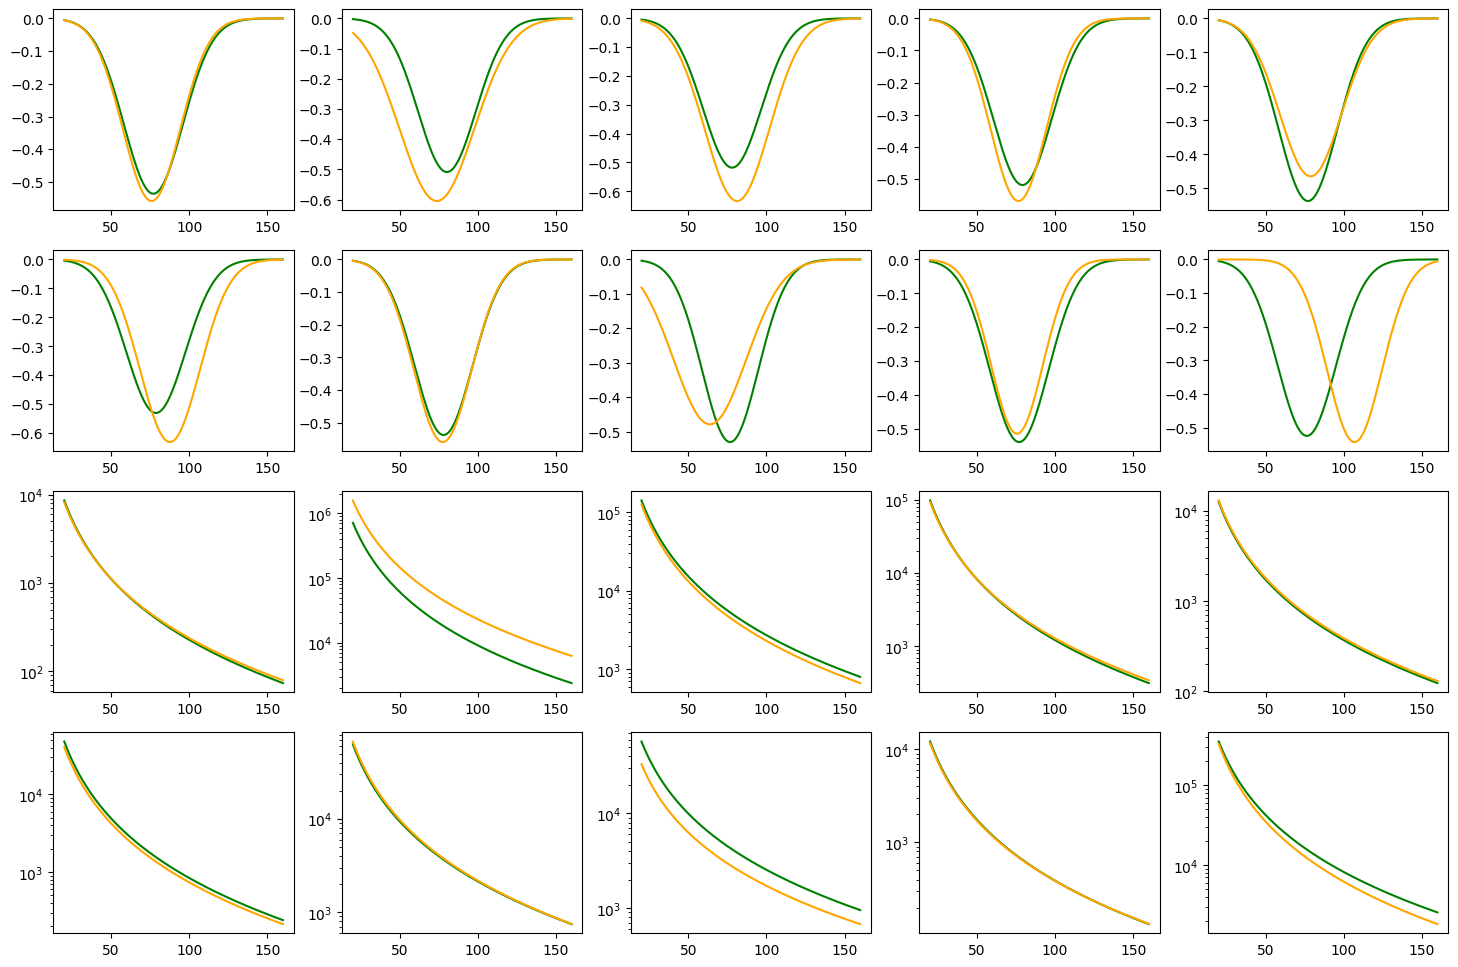

In [ ]:
# np.random.seed(5)
fig,ax = plt.subplots(4,5,figsize=(18,12))
indx = np.random.randint(low=0,high=99,size=10)
print(indx)
for i in range(2):
  if i==0:
    ind = indx[:5]
  else:
    ind = indx[5:]
  for j in range(len(ind)):
    h,y,z,w,u,v,k =Y_pred[ind[j]]
    h1,y1,z1,w1,u1,v1,k1 = Y_test[ind[j]]
    ax[i][j].plot(f,gauss(h,y,z,f),color='green')
    ax[i][j].plot(f,gauss(h1,y1,z1,f),color='orange')
    ax[i+2][j].plot(f,logpoly([w,u,v,k],f,f0),color='green')
    ax[i+2][j].plot(f,logpoly([w1,u1,v1,k1],f,f0),color='orange')
    ax[i+2][j].set_yscale('log')

In [ ]:
h,y,z,w,u,v,i =Y_pred[1]
h1,y1,z1,w1,u1,v1,i1 = Y_test[1]

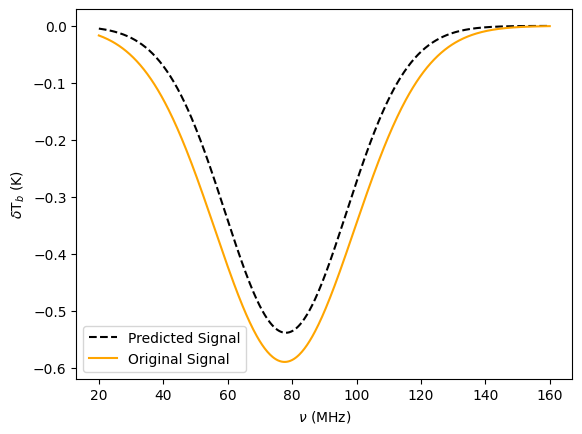

In [ ]:
plt.plot(f,gauss(h,y,z,f),color='black',linestyle='--',label = 'Predicted Signal')
plt.plot(f,gauss(h1,y1,z1,f),color='orange',label = 'Original Signal')
plt.xlabel(r'$\nu$ (MHz)')
plt.ylabel(r'$\delta$T$_b$ (K)')
plt.legend()
plt.savefig("Signal-fore.png")

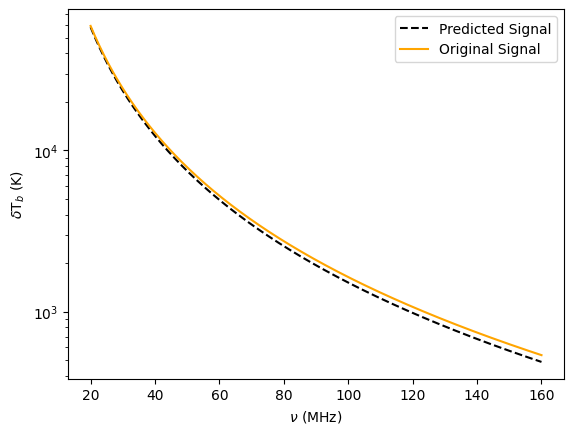

In [ ]:
plt.plot(f,logpoly([w,u,v,i],f,f0),color='black',linestyle='--',label = 'Predicted Signal')
plt.plot(f,logpoly([w1,u1,v1,i1],f,f0),color='orange',label = 'Original Signal')
plt.xlabel(r'$\nu$ (MHz)')
plt.ylabel(r'$\delta$T$_b$ (K)')
plt.yscale('log')
plt.legend()
plt.savefig("fore.png")

In [ ]:
amp, meanh, stdh, a0h,a1h,a2h,a3h = Y_pred.T
ampt, meant, stdt, a0t,a1t,a2t,a3t = Y_test.T

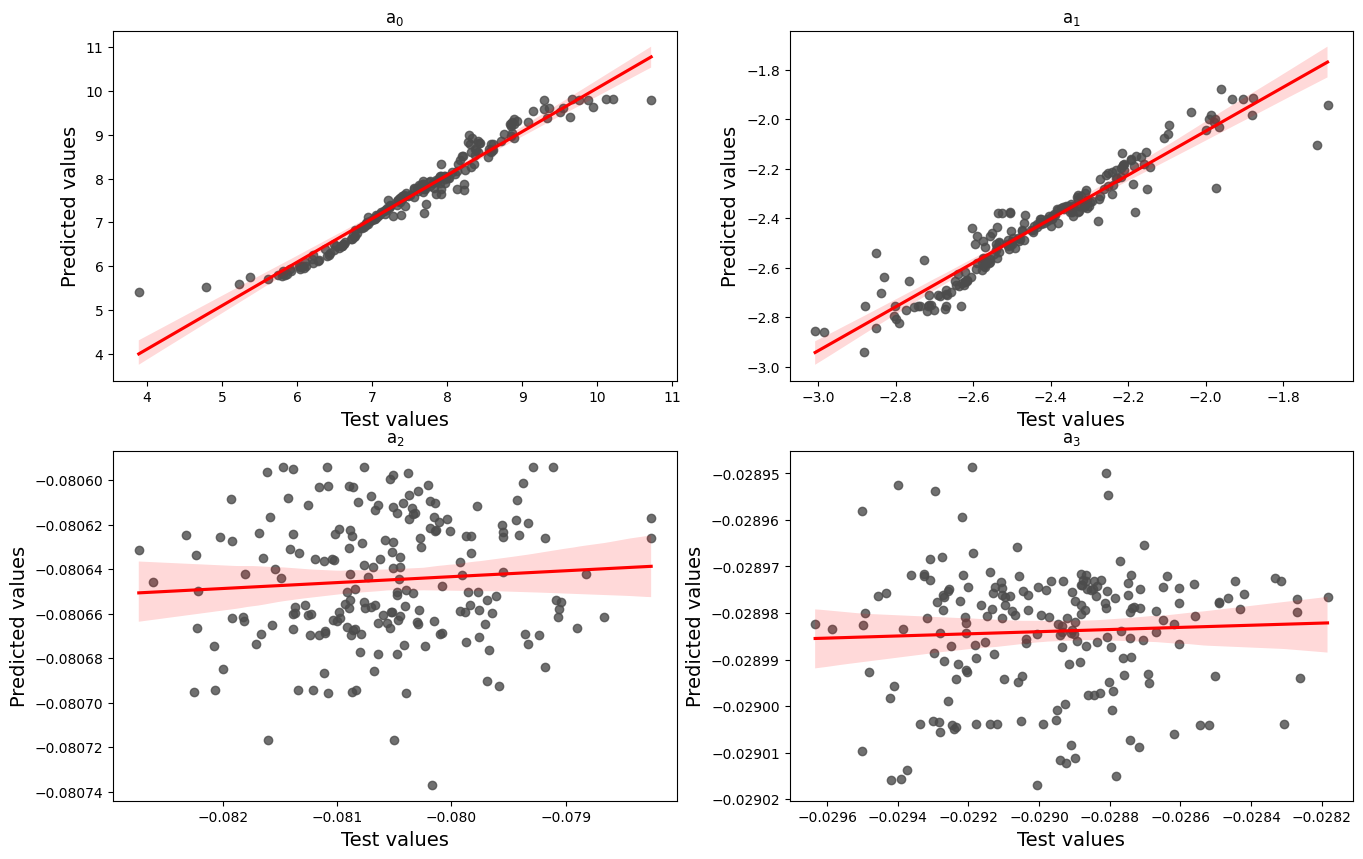

In [ ]:
fig,axe = plt.subplots(2,2,figsize= (16,10))
sns.regplot(x=a0t,y=a0h,ax=axe[0][0],ci=99, marker="o", color=".3", line_kws=dict(color="r"))
sns.regplot(x=a1t,y=a1h,ax=axe[0][1],ci=99, marker="o", color=".3", line_kws=dict(color="r"))
sns.regplot(x=a2t,y=a2h,ax=axe[1][0],ci=99, marker="o", color=".3", line_kws=dict(color="r"))
sns.regplot(x=a3t,y=a3h,ax=axe[1][1],ci=99, marker="o", color=".3", line_kws=dict(color="r"))
axe[0][0].set_xlabel('Test values',fontsize=14)
axe[0][0].set_ylabel('Predicted values',fontsize=14)
axe[0][1].set_xlabel('Test values',fontsize=14)
axe[0][1].set_ylabel('Predicted values',fontsize=14)
axe[1][0].set_xlabel('Test values',fontsize=14)
axe[1][0].set_ylabel('Predicted values',fontsize=14)
axe[1][1].set_xlabel('Test values',fontsize=14)
axe[1][1].set_ylabel('Predicted values',fontsize=14)
axe[0][0].set_title('a$_{0}$')
axe[0][1].set_title('a$_{1}$')
axe[1][0].set_title('a$_{2}$')
axe[1][1].set_title('a$_{3}$')
plt.savefig('predsonly-fore.png')

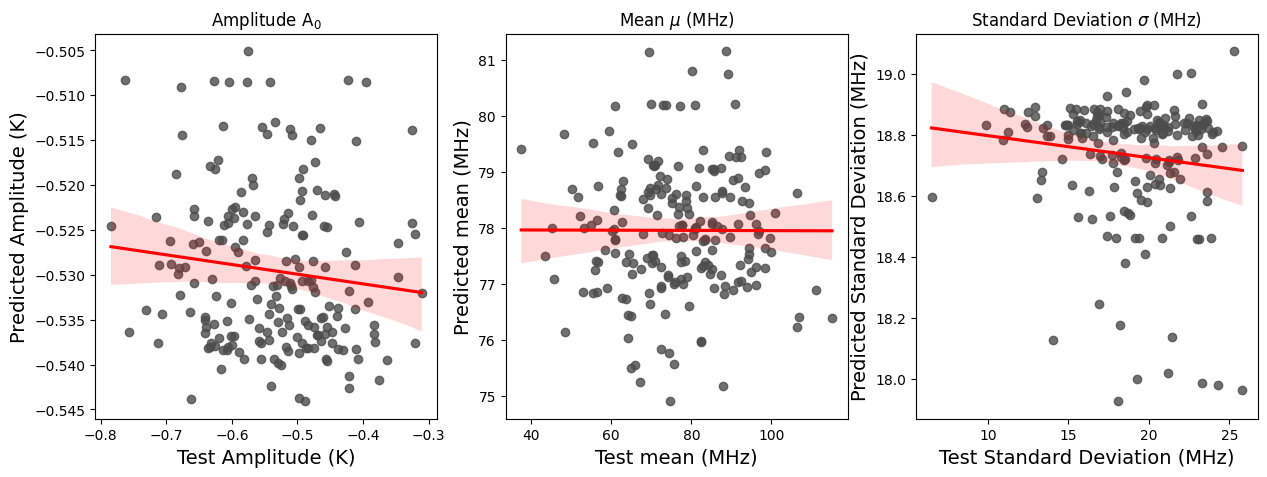

In [ ]:
fig,axe = plt.subplots(1,3,figsize= (15,5))
sns.regplot(x=ampt,y=amp,ax=axe[0],ci=99, marker="o", color=".3", line_kws=dict(color="r"))
sns.regplot(x=meant,y=meanh,ax=axe[1],ci=99, marker="o", color=".3", line_kws=dict(color="r"))
sns.regplot(x=stdt,y=stdh,ax=axe[2],ci=99, marker="o", color=".3", line_kws=dict(color="r"))
axe[0].set_xlabel('Test Amplitude (K)',fontsize=14)
axe[0].set_ylabel('Predicted Amplitude (K)',fontsize=14)
axe[1].set_xlabel('Test mean (MHz)',fontsize=14)
axe[1].set_ylabel('Predicted mean (MHz)',fontsize=14)
axe[2].set_xlabel('Test Standard Deviation (MHz)',fontsize=14)
axe[2].set_ylabel('Predicted Standard Deviation (MHz)',fontsize=14)
axe[0].set_title('Amplitude A$_{0}$')
axe[1].set_title('Mean ' r'$ \mu$ (MHz)')
axe[2].set_title('Standard Deviation ' r'$ \sigma$ (MHz)')
plt.savefig('predsonly-sig.png')